In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
import numpy as np
import datetime
import os, sys

In [3]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [6]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [7]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [8]:
n_noise = 100

In [9]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [11]:
mnist = datasets.MNIST(root='data/', train=True, transform=transform, download=True)

In [12]:
batch_size = 64

In [13]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [14]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [15]:
max_epoch = 5
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [16]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [17]:
!rm -rf samples

In [18]:
os.makedirs('samples')

In [19]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 100 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/step{}.jpg'.format(str(step)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/5, Step: 0, D Loss: 1.3872419595718384, G Loss: 0.6725864410400391
Epoch: 0/5, Step: 100, D Loss: 1.1984221935272217, G Loss: 0.8711985349655151
Epoch: 0/5, Step: 200, D Loss: 1.30379056930542, G Loss: 0.8421114683151245
Epoch: 0/5, Step: 300, D Loss: 1.281760334968567, G Loss: 0.9725220203399658
Epoch: 0/5, Step: 400, D Loss: 1.2966418266296387, G Loss: 1.0648462772369385
Epoch: 0/5, Step: 500, D Loss: 1.3246709108352661, G Loss: 0.8156988024711609
Epoch: 0/5, Step: 600, D Loss: 1.3019146919250488, G Loss: 0.7355486750602722
Epoch: 0/5, Step: 700, D Loss: 1.2619924545288086, G Loss: 0.9472829103469849
Epoch: 0/5, Step: 800, D Loss: 1.2414391040802002, G Loss: 1.0190486907958984
Epoch: 0/5, Step: 900, D Loss: 1.3596835136413574, G Loss: 1.1197047233581543
Epoch: 1/5, Step: 1000, D Loss: 1.3248138427734375, G Loss: 0.7320671677589417
Epoch: 1/5, Step: 1100, D Loss: 1.2750868797302246, G Loss: 1.3243519067764282
Epoch: 1/5, Step: 1200, D Loss: 1.2125697135925293, G Loss: 1.26167

## Visualize Sample

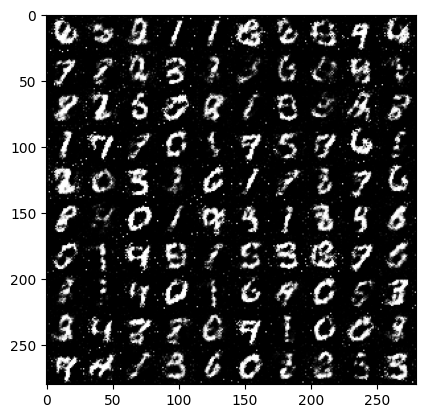

In [20]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')